In [1]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# 1. DATA CLEANING

In [2]:
###' ################################################################################
###'
###' Data Load 
###'
###'

### daata load
df= pd.read_csv("data/6_256(2010-2019).csv")
df.head(5)


df_S = df[['Authors','Title','Year','Volume','Abstract']]
df_clean = df_S.dropna(subset = ['Title','Abstract'])

spell = SpellChecker()
df_clean['Title_spell'] = df_clean['Title'].map(lambda x: spell.correction(x))
df_clean['Abstract_spell'] = df_clean['Abstract'].map(lambda x: spell.correction(x))
df_clean.head(5)

Authors  \
0                                    Wesolowski B.C.   
1           Wang S.; Lin H.; Chang H.-H.; Douglas J.   
2  LaHuis D.M.; Bryant-Lees K.B.; Hakoyama S.; Ba...   
3                  Kang H.-A.; Zhang S.; Chang H.-H.   
4                 Debeer D.; Ali U.S.; van Rijn P.W.   

                                               Title  Year  Volume  \
0  Predicting Operational Rater-Type Classificati...  2019      56   
1  Hybrid Computerized Adaptive Testing: From Gro...  2016      53   
2  A Comparison of Procedures for Estimating Pers...  2018      55   
3  Dual-Objective Item Selection Criteria in Cogn...  2017      54   
4  Evaluating Statistical Targets for Assembling ...  2017      54   

                                            Abstract  \
0  The purpose of this study was to build a Rando...   
1  Computerized adaptive testing (CAT) and multis...   
2  Person reliability parameters (PRPs) model tem...   
3  The development of cognitive diagnostic-comput...   
4  Test assembly is the process of selecting item...   

                                         Title_spell  \
0  Predicting Operational Rater-Type Classificati...   
1  Hybrid Computerized Adaptive Testing: From Gro...   
2  A Comparison of Procedures for Estimating Pers...   
3  Dual-Objective Item Selection Criteria in Cogn...   
4  Evaluating Statistical Targets for Assembling ...   

                                      Abstract_spell  
0  The purpose of this study was to build a Rando...  
1  Computerized adaptive testing (CAT) and multis...  
2  Person reliability parameters (PRPs) model tem...  
3  The development of cognitive diagnostic-comput...  
4  Test assembly is the process of selecting item...

In [3]:
###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    
    # when text is None
    if text is None:  
        return None
    
    # add more stop words
    stop_words = STOP_WORDS 
    nlp.Defaults.stop_words |= {"use","education","measurement","model","Education","Measurement","Model"}
    
    punc = set(punctuation)
    
    
    # remove the punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])                                                               

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # lemmatize
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith(".")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith(".")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

In [4]:
###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

# tokenize
df_clean['A_tokens'] = df_clean['Abstract_spell'].map(lambda x: rem_punc_stop(x))
df_clean['T_tokens'] = df_clean['Title_spell'].map(lambda x: rem_punc_stop(x))

df_clean['A_tokens']
df_clean['T_tokens']

0      [predict, Operational, RaterType, Classificati...
1      [hybrid, Computerized, Adaptive, Testing, Grou...
2      [Comparison, Procedures, Estimating, Person, R...
3      [DualObjective, Item, Selection, Criteria, Cog...
4      [evaluate, statistical, Targets, assemble, Par...
                             ...                        
251                  [note, invariance, dina, parameter]
252                                                 None
253    [comparison, design, equate, mixedformat, test...
254                                                 None
255    [assess, Practical, Equivalence, Conversions, ...
Name: T_tokens, Length: 256, dtype: object

# 2. WORD CLOUDS

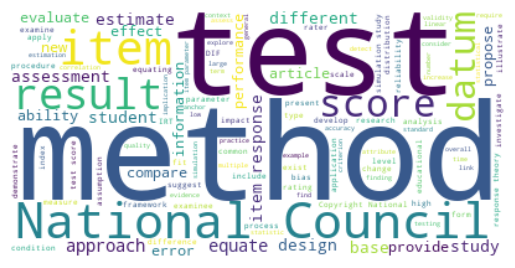

In [5]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###'
###'

### 1. Abstract

# apply function to text object
TO_text = ' '.join(df_clean['A_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
TO_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(TO_text)          

# plot 
plt.imshow(TO_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                              

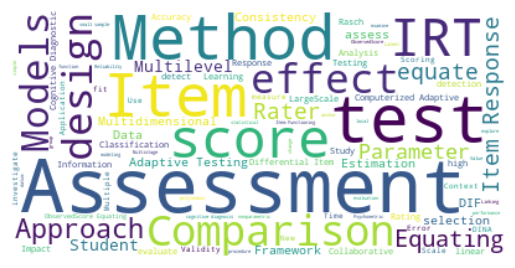

In [6]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###'
###'

### 2. Title

# apply function to text object
TO_text = ' '.join(df_clean['T_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
TO_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(TO_text)          

# plot 
plt.imshow(TO_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                              

# 3. WORDS FREQUENCY

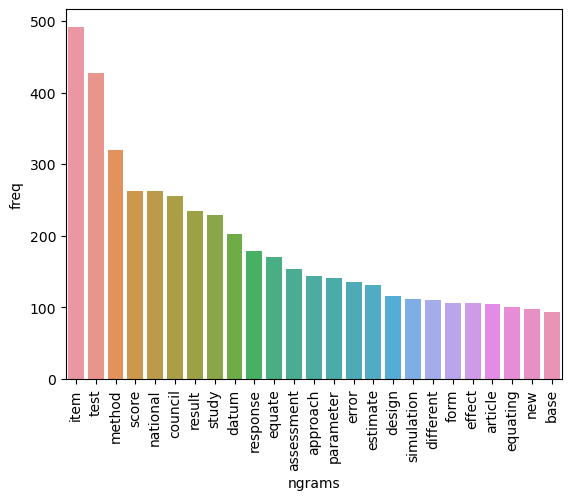

In [7]:
###' ################################################################################
###'
###' VISUALIZATION : WORDS COUNT
###' _ unigrams
###'
###'

### join token
df_clean['A_tokens_join'] = df_clean['A_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")
df_clean['T_tokens_join'] = df_clean['T_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


### most frequent unigrams _____ Abstract one word
countvec = CountVectorizer(min_df = 5, ngram_range=(1,1))
ngrams = countvec.fit_transform(df_clean['A_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

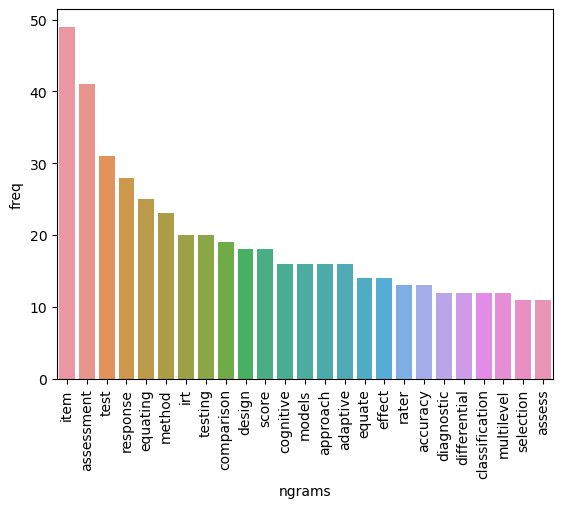

In [8]:
### most frequent unigrams  _____ Title one word
countvec = CountVectorizer(min_df = 5, ngram_range=(1,1))
ngrams = countvec.fit_transform(df_clean['T_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

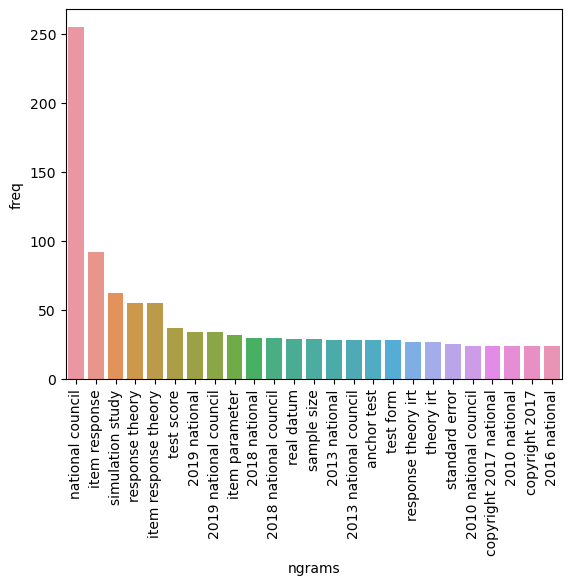

In [9]:
### most frequent bigrams _____ Abstract two words
countvec = CountVectorizer(min_df = 5, ngram_range=(2,3))
ngrams = countvec.fit_transform(df_clean['A_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

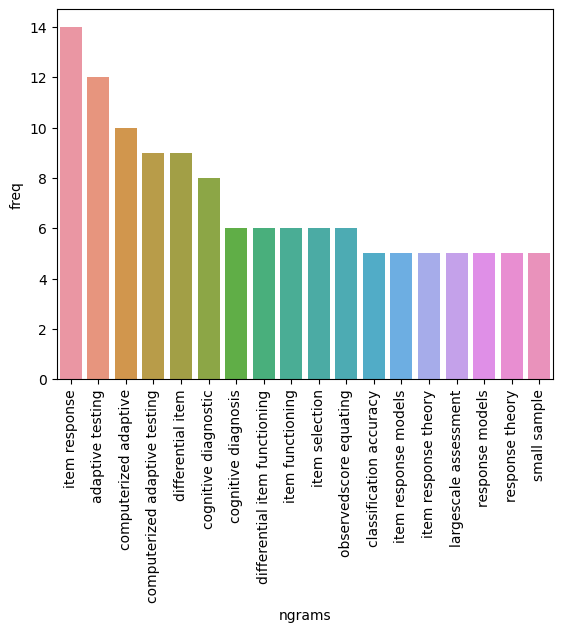

In [10]:
### most frequent bigrams _____ Abstract two words
countvec = CountVectorizer(min_df = 5, ngram_range=(2,3))
ngrams = countvec.fit_transform(df_clean['T_tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

# 4. TOPIC MODELING

In [11]:
###' ################################################################################
###'
###' Topic Modeling : TD-IDF Matrix
###'
###'


### 1. Abstract

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx_a = tfidf.fit_transform(df_clean['A_tokens_join'])



### convert matrix to an arrray and then to a dataframe
tfidf_df_a = pd.DataFrame(data = tfidf_mx_a.toarray(),
                        columns = tfidf.get_feature_names_out())

## sort by term frequency on the first document
tfidf_df_a.T.nlargest(10,0)

0         1    2    3    4         5    6         7    \
rater         0.575853  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
classify      0.249589  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
random        0.181423  0.000000  0.0  0.0  0.0  0.074936  0.0  0.210453   
rasch         0.181423  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
differential  0.168771  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
rate          0.163431  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
analysis      0.142725  0.052644  0.0  0.0  0.0  0.000000  0.0  0.000000   
correctly     0.124794  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
embed         0.124794  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
facet         0.124794  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   

                   8         9    ...       246  247  248  249       250  251  \
rater         0.308486  0.000000  ...  0.607884  0.0  0.0  0.0  0.000000  0.0   
classify      0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   
random        0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   
rasch         0.072892  0.073748  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   
differential  0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   
rate          0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.083157  0.0   
analysis      0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   
correctly     0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   
embed         0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   
facet         0.000000  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0   

                   252  253       254  255  
rater         0.000000  0.0  0.000000  0.0  
classify      0.000000  0.0  0.000000  0.0  
random        0.081045  0.0  0.112274  0.0  
rasch         0.000000  0.0  0.000000  0.0  
differential  0.000000  0.0  0.000000  0.0  
rate          0.000000  0.0  0.000000  0.0  
analysis      0.000000  0.0  0.000000  0.0  
correctly     0.000000  0.0  0.000000  0.0  
embed         0.000000  0.0  0.154458  0.0  
facet         0.000000  0.0  0.000000  0.0  

[10 rows x 256 columns]

In [12]:
###' ################################################################################
###'
###' Topic Modeling : Latent Dirichlet Allocation (LDA)
###'
###'


### define function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nlda_{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

In [13]:
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
X = df_clean['A_tokens_join']

tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None) 

tfidf_mx =  tf.fit_transform(X)

dense_matrix = tfidf_mx.todense()


# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5,
                                max_iter=20,  
                                random_state=0) 

# fit LDA model to our dense matrix
lda = lda.fit(numpy.asarray(dense_matrix))

# post-processing
tf_feature_names = tf.get_feature_names_out()

In [14]:
### print top words 
print_top_words(lda, tf_feature_names, 20)

### join
col_names = ['lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4']
topic_dist = lda.transform(tfidf_mx)
topic_dist_lda = pd.DataFrame(lda.transform(tfidf_mx),
                              columns = col_names)


df_clean = df_clean.join(topic_dist_lda)


lda_0:
equate item test method rater score design study bias dif response examine result chain sample effect form accuracy estimator interruption

lda_1:
test item method rater score parameter assessment information result approach response estimate link design study subscore dif different I level

lda_2:
item equate test irt score form method result error response approach anchor procedure class assessment study polytomous design local national

lda_3:
equate item score datum test method statistic student fit parameter assessment result new cdm article approach error study performance response

lda_4:
item test method datum estimate classification parameter assessment approach study response student analysis index score cognitive result form simulation effect



In [15]:
###' ################################################################################
###'
###' Topic Modeling : on-Negative Matrix Factorization (NMF)
###'
###'


# pre-processing
Y = df_clean['A_tokens_join']

tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None) 

tfidf_mx =  tf.fit_transform(Y)
dense_matrix = tfidf_mx.todense()


# initialize LDA and set model parameters
nmf = NMF(n_components=5,  # specify the number of components
          init='random',   # specify the initalization method
          random_state=1)  # set a seed for reproducibility

# fit NMF model to our dense matrix
nmf = nmf.fit(numpy.asarray(dense_matrix))

# post-processing
tf_feature_names = tf.get_feature_names_out()

In [16]:
### print top words 
print_top_words(nmf, tf_feature_names,20)  

### join
col_names2 = ['nmf_0', 'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4']
topic_dist_nmf = pd.DataFrame(nmf.transform(tfidf_mx),
                              columns = col_names2)

df_clean = df_clean.join(topic_dist_nmf)


lda_0:
item test dif parameter response method estimate study procedure simulation irt estimation new datum approach effect result information ability propose

lda_1:
subscore add value total classification score augment haberman test suggest diagnostic parallel form base correlation reliability cpa method result operational

lda_2:
assessment student score validity interpretation learn evidence approach task educational argument validation teacher performance datum skill process formative collaborative '

lda_3:
equate method anchor score sample observedscore chain design group form equating linear error test equipercentile result transformation bias kernel small

lda_4:
rater rating severity effect ratermediate indicator facet essay tendency quality examine latent hrm system parameter fit central assessment training datum



In [17]:
###' ################################################################################
###'
###' Word Embedding : Word2VecModel
###'
###'


### drop na
tweets_party = df_clean[df_clean['A_tokens'].notna()]

### Train Word2VecModel
model = gensim.models.Word2Vec(df_clean['A_tokens'].tolist(),
                               vector_size = 150, 
                               window = 5, 
                               min_count = 5, 
                               sg = 0, 
                               alpha = 0.025,
                               epochs = 5,
                               seed = 224,
                               batch_words = 10000,
                               workers = 1)

### return list of words
words = list(model.wv.index_to_key)
print(words[0:50]) 

['item', 'test', 'method', 'score', 'National', '©', 'Council', 'result', 'study', 'datum', 'response', 'equate', 'assessment', 'approach', 'parameter', 'error', 'estimate', 'design', 'different', 'form', 'effect', 'article', 'simulation', 'equating', 'new', 'base', 'student', 'IRT', 'provide', 'propose', 'information', 'rater', 'compare', 'performance', 'evaluate', 'anchor', 'standard', 'ability', 'theory', 'suggest', 'examine', 'group', 'procedure', 'sample', 'testing', 'estimation', 'measure', 'distribution', 'level', 'set']


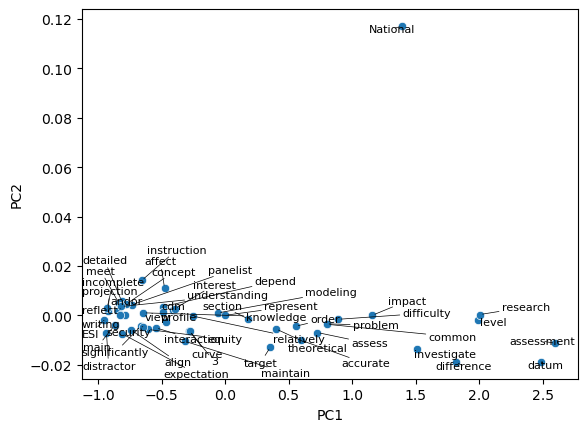

In [18]:
###' ################################################################################
###'
###' Word Embedding : Principal Component Analysis (PCA)
###'
###'


### take random sample
rando = random.sample(list(model.wv.index_to_key), 50) 
X1 = model.wv.__getitem__(rando)

### initalize PCA
pca1 = PCA(n_components=2)
result = pca1.fit_transform(X1)

### convert to dataframe 
result_df = pd.DataFrame(result,                  
                         columns = ['PC1', 'PC2'],
                         index = rando)   

### create scatterplot
sns.scatterplot(x = 'PC1',         # specify x-axis
                y = 'PC2',         # specify y-axis
                data = result_df)  # specify data

### initialize empty list
texts = []

### append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], 
                          result_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))
    
### adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

### plot 
plt.show();

  File "D:\Program\ANACONDA\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


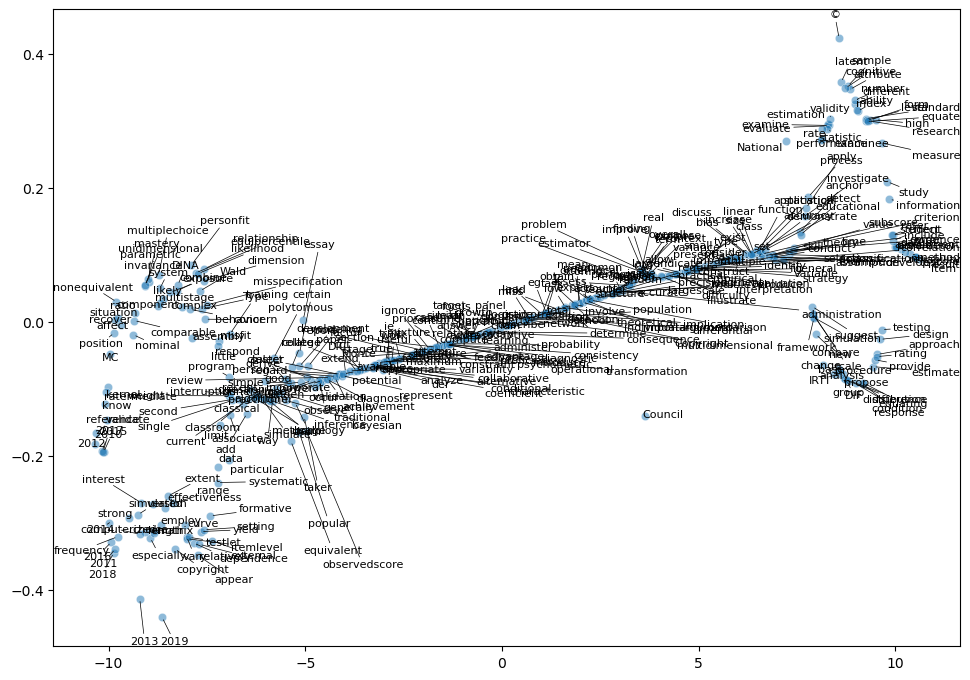

In [19]:
###' ################################################################################
###'
###' Word Embedding : t-SNE
###'
###'


### preprocessing
vector_list = [model.wv.__getitem__(word) for word in words if word in model.wv.index_to_key]
words_filtered = [word for word in words if word in model.wv.index_to_key]
word_vec_zip = zip(words_filtered, vector_list)


### create a dictionary and save as a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape


### initialize t-SNE
tsne = TSNE(n_components = 2,  # specify 2 components
            init = 'random',   # set initalization
            random_state = 10, # set seed
            perplexity = 100)  # set preplexity threshold


### subset to only 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])


### figure specifications
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], 
                y = tsne_df[:, 1], 
                alpha = 0.5)


### Convert tsne_df to DataFrame
tsne_df = pd.DataFrame(tsne_df, index=words_filtered[:400], columns=['PC1', 'PC2'])

### Initialize empty list
texts = []

### Append words to list using loop
for word in tsne_df.index:
    texts.append(plt.text(tsne_df.loc[word, 'PC1'], 
                          tsne_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))

### Adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

plt.show()

In [21]:
csv_file_path = 'data/6_output.csv'
df_clean.to_csv(csv_file_path, index=False)